# Tokenize and save data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '../..')
from src.encode_data import *
from src.fastai_data import *

In [3]:
import pandas as pd
import numpy as np

In [4]:
from fastai.text import *

In [5]:
from fastai.text import data

## Preparing the data

In [6]:
version = 'v14'
data_path = Path('data/midi')
version_path = data_path/version

In [7]:
source_dir = 'piano_duet'
out_path = version_path/source_dir
csv_path = out_path/f'{source_dir}.csv'
version_path.ls()

[PosixPath('data/midi/v14/metadata'),
 PosixPath('data/midi/v14/midi_sources'),
 PosixPath('data/midi/v14/midi_encode'),
 PosixPath('data/midi/v14/piano_duet')]

In [8]:
csv = pd.read_csv(csv_path)
csv = csv.loc[csv['numpy'].notna()];

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,7,8,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
def create_databunch(files, cache_name, batch_size=32, load_cached=False):
    if load_cached and (out_path/f'{cache_name}/train_ids.npy').exists():
        data = MusicDataBunch.load(out_path, bs=batch_size, cache_name=cache_name)
    else:
        ps = [OpenNPFileProcessor()]

        data = (MusicItemList(items=files, path=out_path, processor=ps)
                .split_by_rand_pct(0.01, seed=6)
                .label_const(label_cls=LMLabelList))
        data = data.databunch(bs=batch_size)
        data.save(cache_name)
    return data

In [10]:
def get_files(csv):
    files = csv['numpy']
    flist = [Path(version_path/f) for f in files.values]
    flist = [f for f in flist if f.exists()]
    return flist

In [11]:
version_path

PosixPath('data/midi/v14')

### Create All Dataset

In [12]:
csv.head()

,artist,ht_time_signature,ht_offset,song_url,midi,source,genres,section,midi_title,md5,ht_bpm,title,ht_mode,numpy,parts,ht_key,mxl
0,wayne-sharpe,4.0,0.0,https://www.hooktheory.com/theorytab/view/wayn...,midi_sources/hooktheory/pianoroll/w/wayne-shar...,hooktheory,NaN,chorus,yu-gi-oh3,bf1f29e5ff84e3e93e37fb873bfb590e,128.0,yu-gi-oh-theme-song,1.0,piano_duet/hooktheory/pianoroll/w/wayne-sharpe...,"intro,chorus",C,NaN
1,wayne-sharpe,3.0,0.0,https://www.hooktheory.com/theorytab/view/wayn...,midi_sources/hooktheory/pianoroll/w/wayne-shar...,hooktheory,NaN,intro,yu-gi-oh,055f80ad67f64edb14a85ca8fbfe8c29,85.0,yu-gi-oh-theme-song,1.0,piano_duet/hooktheory/pianoroll/w/wayne-sharpe...,"intro,chorus",C,NaN
2,what-a-day,4.0,-5.0,https://www.hooktheory.com/theorytab/view/what...,midi_sources/hooktheory/pianoroll/w/what-a-day...,hooktheory,Jazz,chorus,kiefer,197f96f5d181f6ce1e2c5ab04ac1ff87,96.0,kiefer,6.0,piano_duet/hooktheory/pianoroll/w/what-a-day/k...,chorus,D,NaN
3,whiteflame,4.0,-5.0,https://www.hooktheory.com/theorytab/view/whit...,midi_sources/hooktheory/pianoroll/w/whiteflame...,hooktheory,"J-Pop,Pop",pre-chorus,senbonzakura - pre-Pre-Chorus,9e7ce13a35f1314423a9a6d5a5287a4a,152.0,senbonzakura,6.0,piano_duet/hooktheory/pianoroll/w/whiteflame/s...,"verse,pre-chorus,chorus",D,NaN
4,whiteflame,4.0,-5.0,https://www.hooktheory.com/theorytab/view/whit...,midi_sources/hooktheory/pianoroll/w/whiteflame...,hooktheory,"J-Pop,Pop",verse,Senbonzakura,d5aaf79d0989222f1362f9f46c540a27,152.0,senbonzakura,6.0,piano_duet/hooktheory/pianoroll/w/whiteflame/s...,"verse,pre-chorus,chorus",D,NaN


In [13]:
csv.shape

(112614, 17)

In [14]:
all_files = get_files(csv)

In [ ]:
all_data = create_databunch(all_files, cache_name='tmp/all', load_cached=True)

### Create sample

In [15]:
import random
sample_data = create_databunch(random.sample(all_files, 1000), cache_name='tmp/sample')

DLTFMS: None


Note: we are reusing all_vocab for the following datasets

### Save vocab sizes

In [16]:
VOCAB_SZ = create_vocab_sizes(out_path/'tmp/all'); VOCAB_SZ

[117, 146]

### Create Hooktheory C Dataset

In [17]:
hook_csv = csv.loc[csv.source.isin(['hooktheory_c'])]
hook_files = get_files(hook_csv); len(hook_files)

19982

In [18]:
hook_data = create_databunch(hook_files, cache_name='tmp/hook_c')

### Create Classical Dataset

In [19]:
from collections import Counter

In [20]:
Counter(csv.source)

Counter({'hooktheory': 19820,
         'freemidi': 1859,
         'midiworld': 1752,
         'ecomp': 2519,
         'cprato': 218,
         'classical_piano': 326,
         'classical_archives': 4788,
         'musescore': 9189,
         'wikifonia': 3912,
         'lmd': 4946,
         'reddit': 43303,
         'hooktheory_c': 19982})

In [21]:
clc_csv = csv.loc[csv.source.isin(['classical_piano', 'ecomp', 'musescore', 'wikifonia', 'classical_archives'])]
clc_files = get_files(clc_csv); len(clc_files)

20734

In [22]:
clc_data = create_databunch(clc_files, cache_name='tmp/clc')

In [23]:
len(clc_files)

20734

## Low quality

In [24]:
lq_csv = csv.loc[csv.source.isin(['reddit', 'classical_archives', 'classical_piano', 'ecomp', 'midiworld', 'freemidi', 'lmd', 'cprato', 'wikifonia'])]
lq_files = get_files(lq_csv); len(lq_files)

63623

In [25]:
lq_data = create_databunch(lq_files, cache_name='tmp/lq')

## All High quality

In [26]:
hq_csv = csv.loc[csv.source.isin(['hooktheory', 'musescore'])]
hq_files = get_files(hq_csv); len(hq_files)

29009

In [27]:
hq_data = create_databunch(hq_files, cache_name='tmp/hq')

### Testing

In [28]:
data = all_data

In [29]:
data.train_ds.x

LMNPItemList (90944 items)
[[  2 135]
 [  1   5]
 [ 58   4]
 [  1   4]
 ...
 [  1  11]
 [ 61  19]
 [ 57  19]
 [ 54  19]],[[  2 135]
 [  1   4]
 [ 68   4]
 [  1   4]
 ...
 [  1   4]
 [ 70   7]
 [  1   7]
 [ 70  15]],[[  2 135]
 [  1   4]
 [ 75   4]
 [ 68   9]
 ...
 [  1   4]
 [ 65   5]
 [  1   5]
 [ 67   5]],[[  2 135]
 [  1   4]
 [ 68   7]
 [ 56  19]
 ...
 [  1  15]
 [ 65   5]
 [  1   5]
 [ 68   5]],[[  2 135]
 [  1   4]
 [ 65   7]
 [ 60  19]
 ...
 [ 55  11]
 [ 51  11]
 [  1   7]
 [ 65   7]]
Path: data/midi/v13/piano_duet

In [ ]:
# train_ids_file = out_path/'tmp/all/train_ids.npy'
# all_ids = np.load(train_ids_file)
# id_cat = np.concatenate(all_ids); id_cat.shape
# ax = tuple(range(len(id_cat.shape)-1))
# max_vocab = id_cat.max(axis=ax)
# max_vocab = (max_vocab+1).tolist(); max_vocab

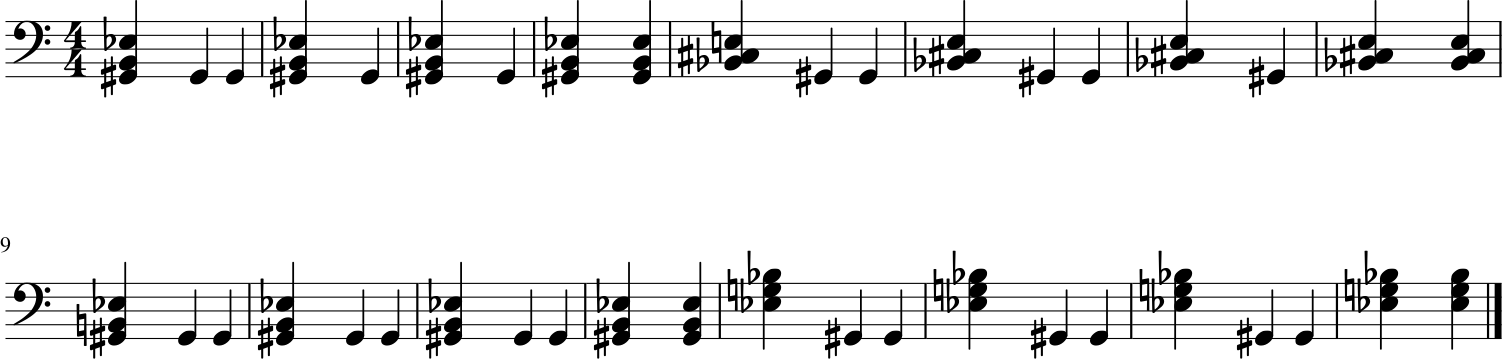

In [18]:
npenc2stream(data.train_ds.x[10]).show()